In [1]:
import skimage.io as io
import numpy as np
import random
import matplotlib.pyplot as plt
import albumentations as A
import os
import time

Hyperparameters

In [2]:
crop_size = 400, 400
patch_size = 100, 100
n_scale = 2
patch_overlap = 0.5
n_classes = 2

Listing images and masks

In [3]:
dataset_name = 'coffee-scenes'
img_names = os.listdir(os.path.join(dataset_name, 'images'))
mask_names = os.listdir(os.path.join(dataset_name, 'masks'))

# test: guaxupe
# val: arceburgo
ignore_set = ['guaxupe.tif', 'arceburgo.tif']


for ignore in ignore_set:
    img_names.remove(ignore)
    mask_names.remove(ignore)
print(img_names)
print(mask_names)

['guaranesia.tif', 'montesanto.tif']
['guaranesia.tif', 'montesanto.tif']


Calculating class percentage

In [12]:
class_samples = np.zeros(n_classes)
d = {}
for msk in mask_names:
    print(msk, end="\r", flush=True)
    mask = io.imread(os.path.join(dataset_name, 'masks', msk)).flatten()
    pixel, count = np.unique(mask, return_counts=True)
    for p, c in zip(pixel, count):
        if p in d:
            d[p] += c
        else:
            d[p] = c

print(d)   

{0: 253688629, 255: 22454732}


In [13]:
class_proportion = {}
s = sum(d.values())
for k, v in d.items():
    pct = v * 100.0 / s
    class_proportion[k] = pct
    
print('Proportion: ', class_proportion)

max_class = max(class_proportion.values())
class_weight = {}
for k, v in class_proportion.items():
    class_weight[k] = max_class/v
    
print('Class weight: ', class_weight)

Proportion:  {0: 91.86845125709903, 255: 8.131548742900975}
Class weight:  {0: 1.0, 255: 11.297780307509347}


<BarContainer object of 2 artists>

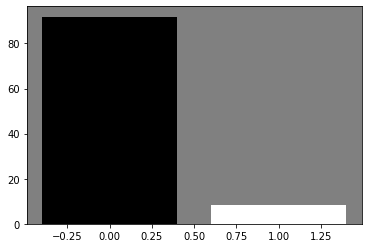

In [15]:
plt.rcParams['axes.facecolor'] = 'gray'
colors = ['black' if k == 0 else 'white' for k in class_proportion.keys()]
plt.bar(range(n_classes), class_proportion.values(), color=colors)

Gini index calculation

In [24]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    aux = array.flatten()
    filtered = aux[aux != 0]
    array = filtered
    
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [ ]:
# mean_gini = 0
# for msk in mask_names:
#     print(msk, end="\r", flush=True)
#     mask = io.imread(os.path.join(dataset_name, 'masks', msk)).flatten()
#     mask[mask == 0] = 1
#     mask[mask == 255] = 2
#     mean_gini += gini_coefficient(mask)
    
# mean_gini /= len(mask_names)
# print()
# print(mean_gini)

Patches' probabilities preparation

In [26]:
def calculate_prob(patch, class_weight):
    patch = patch.flatten()
    pixel, count = np.unique(patch, return_counts=True)
    prob = 0
    for p, c in zip(pixel, count):
        prob += class_weight[p] * c
        
    return prob
    
    
def generate_patch_probs(mask_name, mask, patch_size, patch_overlap, class_weight, scale):
    probs = []
    row = 0
    col = 0
    max_row, max_col = mask.shape
    p_size = (patch_size[0]*scale, patch_size[1]*scale)
    while row < max_row - p_size[0]:
        col = 0
        while col < max_col - p_size[1]:
            row_end = row + p_size[0]
            col_end = col + p_size[1]
            patch = mask[row:row_end, col:col_end]
            prob = calculate_prob(patch, class_weight)
            probs.append((mask_name, prob, row, p_size[0], col, p_size[0]))
            col += int(p_size[1]*(1-patch_overlap))
        row += int(p_size[0]*(1-patch_overlap))
    return probs

In [27]:
# patch_prob = [(img_name, value, start_row, row_size, start_col, col_size)]
patch_prob = {}
for scale in range(1, n_scale + 1):
    patch_prob[scale] = []
    for mask_name in mask_names:
        print(scale, mask_name, end="\r", flush=True)
        mask = io.imread(os.path.join(dataset_name, 'masks', mask_name))
        patch_prob[scale].extend(generate_patch_probs(mask_name, mask, patch_size, patch_overlap, class_weight, scale))

In [28]:
sum_probs = {}
for scale in range(1, n_scale+1):
    sum_probs[scale] = 0
    for p in patch_prob[scale]:
        sum_probs[scale] += p[1]

Generating new images

In [77]:
def select_patch(prob, prob_sum):
    array = np.array(prob)
    array_prob = array[:,1].astype(np.float)
    array_prob = array_prob/prob_sum
    choice = np.random.choice(len(prob), p=array_prob)
    choice = prob[choice]
    img = io.imread(os.path.join(dataset_name, 'images', choice[0]))
    mask = io.imread(os.path.join(dataset_name, 'masks', choice[0]))
    img_patch = img[choice[2] : choice[2] + choice[3], 
                    choice[4] : choice[4] + choice[5], :]
    mask_patch = mask[choice[2] : choice[2] + choice[3], 
                    choice[4] : choice[4] + choice[5]]
    mask_patch[mask_patch == 0] = 127
    while tuple(img_patch[0,0]) == (0,0,0) and tuple(img_patch[-1,-1]) == (0,0,0):
        choice = np.random.choice(len(prob), p=array_prob)
        choice = prob[choice]
        img = io.imread(os.path.join(dataset_name, 'images', choice[0]))
        mask = io.imread(os.path.join(dataset_name, 'masks', choice[0]))
        img_patch = img[choice[2] : choice[2] + choice[3], 
                        choice[4] : choice[4] + choice[5], :]
        mask_patch = mask[choice[2] : choice[2] + choice[3], 
                        choice[4] : choice[4] + choice[5]]
        mask_patch[mask_patch == 0] = 127
    return img_patch, mask_patch

def transform_patch(img, mask):
    aug = A.Compose([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        #A.Rotate(p=0.5),
        A.Transpose(p=0.5),
        A.OneOf([
            #A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.8),
            A.Perspective(p=0.8),
            #A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.5)])

    augmented = aug(image=img, mask=mask)
    image_transformed = augmented['image']
    mask_transformed = augmented['mask']
    
    return image_transformed, mask_transformed

# scale = 1
# a,b = select_patch(patch_prob[scale], sum_probs[scale])
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
# axes[0].imshow(a)
# axes[1].imshow(b,cmap='gray')

In [78]:
def generate_image(n_scale, crop_size, p_size):
    scale = random.randint(1, n_scale)
    patch_size = (p_size[0]*scale, p_size[1]*scale)
    new_img = np.zeros((crop_size[0], crop_size[1], 3))
    new_mask = np.zeros((crop_size[0], crop_size[1]))
    
    n_rows = crop_size[0]//(patch_size[0])
    n_cols = crop_size[0]//(patch_size[0])
    row = 0
    col = 0
    while row < n_rows:
        if row % 2 == 0:
            col = 0
            while col < n_cols-1:
                img_patch, mask_patch = select_patch(patch_prob[scale], sum_probs[scale])
                img_patch, mask_patch = transform_patch(img_patch, mask_patch)
                row_start = patch_size[0]*row
                row_end = patch_size[0]*row + patch_size[0]
                col_start = patch_size[1]*col
                col_end = patch_size[1]*col + patch_size[1]
                new_img[row_start:row_end, col_start:col_end, :] = img_patch
                new_mask[row_start:row_end, col_start:col_end] = mask_patch

                flip_col_start = col_start+patch_size[1]
                flip_col_end = col_end+patch_size[1]

                new_img[row_start:row_end, flip_col_start:flip_col_end,:] = np.flip(img_patch, 1)
                col += 2
        else:
            col = 1
            while col < n_cols:
                img_patch, mask_patch = select_patch(patch_prob[scale], sum_probs[scale])
                row_start = patch_size[0]*row
                row_end = patch_size[0]*row + patch_size[0]
                col_start = patch_size[1]*col
                col_end = patch_size[1]*col + patch_size[1]
                new_img[row_start:row_end, col_start:col_end, :] = img_patch
                new_mask[row_start:row_end, col_start:col_end] = mask_patch

                flip_col_start = col_start-patch_size[1]
                flip_col_end = col_end-patch_size[1]

                new_img[row_start:row_end, flip_col_start:flip_col_end,:] = np.flip(img_patch, 1)
                col += 2
        row += 1

    new_img = new_img.astype(np.uint8)
    new_mask = new_mask.astype(np.uint8)
    
    return new_img, new_mask

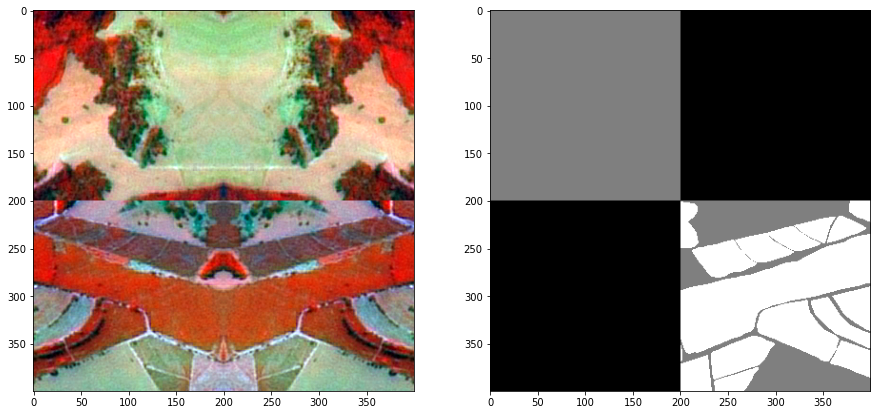

In [79]:
new_img, new_mask = generate_image(n_scale, crop_size, patch_size)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
axes[0].imshow(new_img)
axes[1].imshow(new_mask, cmap='gray')

In [80]:
#!rm -r new_data
!mkdir coffee_new_data
!mkdir coffee_new_data/images
!mkdir coffee_new_data/masks
!cd coffee_new_data && ls

images	masks


In [81]:
n_images = 1000
new_images = []
new_masks = []
for i in range(n_images):
    print(i, end="\r", flush=True)
    new_img, new_mask = generate_image(n_scale, crop_size, patch_size)
    new_images.append(new_img)
    new_masks.append(new_mask)

In [17]:
# new_gini = 0
# for i, new_mask in enumerate(new_masks):
#     print(i, end="\r", flush=True)
#     new_gini += gini(new_mask)
    
# new_gini /= len(new_masks)
# print('\nold: ', mean_gini)
# print('new: ', (new_gini+mean_gini)/2)

In [82]:
cont = 0
for img, msk in zip(new_images, new_masks):
    io.imsave(os.path.join('coffee_new_data', 'images', str(cont)+'.png'), img)
    io.imsave(os.path.join('coffee_new_data', 'masks', str(cont)+'.png'), msk)
    cont += 1 